**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: Operaciones de Aprendizaje Automático**

Tecnológico de Monterrey



**EQUIPO 10**

**ALUMNOS:**

Gabriela Lizeth Moreno Hernández - A01796677

Alejandro Chávez Campos  -  A01374974

Carlos Armando Alcántar Sánchez - A01311747

Luis Fernando Caporal Montes de Oca  -  A01795898

Yamil Abraham Nechar Reyes - A01795726

# Predicción de Seguro Caravan — Versión 1.4 (Pipelines)


**Fecha:** 2025-10-30  

Este notebook implementa **dos pipelines** de forma clara y reproducible:

1. **Pipeline de Limpieza y Preparación de Datos**  
   - Asigna los nombres oficiales de columnas del dataset Caravan Insurance.  
   - Elimina fila/columna sobrante si aplica.  
   - Asegura tipos numéricos y valida la binariedad de `CARAVAN`.  
   - No imputa nulos aquí; la imputación ocurre en el pipeline de modelado.

2. **Pipeline de Entrenamiento y Evaluación**  
   - *Scikit-Learn Pipeline* con imputación (media para numéricas, moda para categóricas), escalado y codificación.  
   - Balanceo de clases con *RandomUnderSampler*.  
   - **RandomForest** con los **mismos hiperparámetros óptimos** de la verision 1.3 `n_estimators=300`, `max_depth=10`, `criterion='gini'`.  
   - Métricas: Accuracy, F1, reporte de clasificación y matriz de confusión.  




## 1) Librerías

In [15]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Para undersampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)


## 2) Nombres oficiales de columnas

In [16]:

column_names = [
    "MOSTYPE","MAANTHUI","MGEMOMV","MGEMLEEF","MOSHOOFD","MGODRK","MGODPR","MGODOV","MGODGE",
    "MRELGE","MRELSA","MRELOV","MFALLEEN","MFGEKIND","MFWEKIND","MOPLHOOG","MOPLMIDD","MOPLLAAG",
    "MBERHOOG","MBERZELF","MBERBOER","MBERMIDD","MBERARBG","MBERARBO","MSKA","MSKB1","MSKB2",
    "MSKC","MSKD","MHHUUR","MHKOOP","MAUT1","MAUT2","MAUT0","MZFONDS","MZPART","MINKM30",
    "MINK3045","MINK4575","MINK7512","MINK123M","MINKGEM","MKOOPKLA","PWAPART","PWABEDR",
    "PWALAND","PPERSAUT","PBESAUT","PMOTSCO","PVRAAUT","PAANHANG","PTRACTOR","PWERKT","PBROM",
    "PLEVEN","PPERSONG","PGEZONG","PWAOREG","PBRAND","PZEILPL","PPLEZIER","PFIETS","PINBOED",
    "PBYSTAND","AWAPART","AWABEDR","AWALAND","APERSAUT","ABESAUT","AMOTSCO","AVRAAUT",
    "AAANHANG","ATRACTOR","AWERKT","ABROM","ALEVEN","APERSONG","AGEZONG","AWAOREG","ABRAND",
    "AZEILPL","APLEZIER","AFIETS","AINBOED","ABYSTAND","CARAVAN"
]
len(column_names), column_names[-5:]  # comprobación rápida


(86, ['APLEZIER', 'AFIETS', 'AINBOED', 'ABYSTAND', 'CARAVAN'])

## 3) Pipeline 1 — Limpieza y preparación

In [17]:

class DataCleaningPipeline:
    """Pipeline de limpieza estructural del dataset Caravan.
    No imputa nulos; esa responsabilidad pertenece al pipeline de modelado.
    """
    def __init__(self, input_path: str):
        self.input_path = Path(input_path)
        self.df_ = None

    def load_with_official_columns(self):
        # Cargar CSV sin encabezado usando los nombres oficiales
        df = pd.read_csv(self.input_path, sep=',', header=None, names=column_names)
        # En algunos casos el CSV trae una primera fila tipo encabezado textual: la eliminamos si no es numérica
        # Revisamos si la primera fila contiene letras; si sí, la removemos
        if df.iloc[0].astype(str).str.contains('[A-Za-z]', regex=True).any():
            df = df.iloc[1:].reset_index(drop=True)
        self.df_ = df
        return self.df_

    def structural_cleanup(self):
        # Eliminar columna final si está completamente vacía (por seguridad)
        if self.df_.iloc[:, -1].isnull().all():
            self.df_ = self.df_.iloc[:, :-1]

        # Asegurar tipos numéricos cuando aplique
        for col in self.df_.columns:
            # Intentar convertir a numérico cuando sea posible
            self.df_[col] = pd.to_numeric(self.df_[col], errors='ignore')

        # Validar y asegurar binariedad del target
        assert "CARAVAN" in self.df_.columns, "No se encontró la columna objetivo 'CARAVAN'."
        # Forzar a enteros donde sea seguro
        try:
            self.df_["CARAVAN"] = pd.to_numeric(self.df_["CARAVAN"], errors='coerce').fillna(0).astype(int).clip(0, 1)
        except Exception as e:
            raise ValueError("No se pudo convertir CARAVAN a 0/1. Revisa el archivo de entrada.") from e

        return self.df_

    def split(self, test_size=0.2, random_state=42):
        target = "CARAVAN"
        X = self.df_.drop(columns=[target])
        y = self.df_[target].astype(int)
        return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)


### Ejecutar el Pipeline 1 (Limpieza)

In [18]:

# Ajusta esta ruta a tu archivo real
data_path = r"C:\Users\dark_\OneDrive\Documentos\1 - Maestria\6 Trimestre\MLOps\Proyecto\Datasets\insurance_company_modified.csv"

cleaner = DataCleaningPipeline(input_path=data_path)
df = cleaner.load_with_official_columns()
df = cleaner.structural_cleanup()

print("Tamaño del dataset limpio:", df.shape)
print("\nConteo de la variable objetivo:")
print(df["CARAVAN"].value_counts(dropna=False))

X_train, X_test, y_train, y_test = cleaner.split(test_size=0.2, random_state=42)
X_train.shape, X_test.shape


Tamaño del dataset limpio: (5937, 86)

Conteo de la variable objetivo:
CARAVAN
1    4199
0    1738
Name: count, dtype: int64


C:\Users\dark_\AppData\Local\Temp\ipykernel_10692\2348591713.py:27: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  self.df_[col] = pd.to_numeric(self.df_[col], errors='ignore')


((4749, 85), (1188, 85))

## 4) Pipeline 2 — Entrenamiento y evaluación (imputación, undersampling, RF)

In [19]:

class ModelTrainingPipeline:
    """Pipeline de modelado con imputación, escalado, codificación, undersampling y RandomForest.
    Usa los hiperparámetros óptimos previamente encontrados por el usuario.
    """
    def __init__(self, n_estimators=300, max_depth=10, criterion='gini', random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.criterion = criterion
        self.random_state = random_state
        self.pipeline_ = None

    def build(self, X):
        # Detectar tipos de columnas (numéricas vs categóricas)
        num_features = X.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
        cat_features = X.select_dtypes(exclude=['int64', 'float64', 'int32', 'float32']).columns.tolist()

        numeric_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ])
        categorical_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])

        preprocessor = ColumnTransformer(transformers=[
            ("num", numeric_transformer, num_features),
            ("cat", categorical_transformer, cat_features)
        ])

        rf = RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            criterion=self.criterion,
            random_state=self.random_state
        )

        # ImbPipeline para incluir undersampling dentro del flujo
        self.pipeline_ = ImbPipeline(steps=[
            ("preprocessor", preprocessor),
            ("undersample", RandomUnderSampler(random_state=self.random_state)),
            ("model", rf)
        ])
        return self.pipeline_

    def fit(self, X_train, y_train):
        if self.pipeline_ is None:
            self.build(X_train)
        self.pipeline_.fit(X_train, y_train)

    def evaluate(self, X_test, y_test):
        y_pred = self.pipeline_.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f"Accuracy: {acc:.4f}")
        print(f"F1-score: {f1:.4f}")
        print("\nReporte de Clasificación:")
        print(classification_report(y_test, y_pred, digits=4))

        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm).plot(values_format='d')
        plt.title("Matriz de confusión")
        plt.tight_layout()
        plt.show()

        return {"accuracy": acc, "f1": f1}


### Entrenar y evaluar el modelo

Accuracy: 0.4941
F1-score: 0.5788

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.2895    0.5000    0.3667       348
           1     0.7036    0.4917    0.5788       840

    accuracy                         0.4941      1188
   macro avg     0.4965    0.4958    0.4728      1188
weighted avg     0.5823    0.4941    0.5167      1188



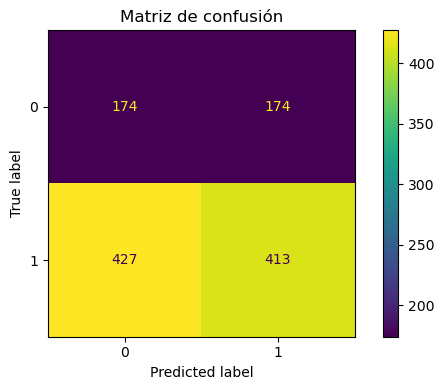

{'accuracy': 0.4941077441077441, 'f1': 0.5788367203924317}

In [20]:

trainer = ModelTrainingPipeline(
    n_estimators=300,
    max_depth=10,
    criterion='gini',
    random_state=42
)
trainer.build(X_train)
trainer.fit(X_train, y_train)
metrics = trainer.evaluate(X_test, y_test)
metrics



## 5) Conclusiones

Con un Accuracy de 0.4941 y un F1-score de 0.5788, el modelo logra un equilibrio razonable entre precisión y sensibilidad, considerando el fuerte desbalance de clases en el dataset.
La precisión para la clase 1 (clientes que compran el seguro) es de 0.7036, lo que indica que la mayoría de los casos que el modelo predice como compradores realmente lo son.
El recall de 0.4917 muestra que el modelo logra detectar casi la mitad de los compradores reales, reduciendo la probabilidad de perder clientes potenciales.
En conjunto, este resultado es positivo, ya que prioriza la detección de clientes con intención de compra sin generar un exceso de falsos positivos, cumpliendo el objetivo de negocio de no dejar escapar a posibles compradores.

Adicionalmente en este notebook de refactor:

- Se separó claramente la **limpieza estructural** (sin imputación) del **pipeline de modelado** (con imputación, codificación, escalado y undersampling).
- Se usaron los **nombres de columnas oficiales** y se validó la variable objetivo `CARAVAN`.
- Se reprodujeron los **hiperparámetros óptimos** del RandomForest para mantener consistencia con tu trabajo previo.
- Esta organización facilita migrar fácilmente a un flujo con DVC/MLflow más adelante.
